In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/roberta-weights/model.h5
/kaggle/input/mumbai-2-tweets/finalmumbai-2.csv


In [2]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

2022-02-14 16:39:13.052065: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [4]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 35
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 2

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

In [5]:
df = pd.read_csv('../input/mumbai-2-tweets/finalmumbai-2.csv')
df = df.drop(['Unnamed: 0'],axis=1)
df = df[['id','date','content']]
df = df.reset_index(drop = True)
df

,id,date,content
0,1.432838e+18,2021-08-31,bjp wake smell grass fool people sometimes can...
1,1.432837e+18,2021-08-31,add kamla raman nagar baiganwadi govandi behin...
2,1.432837e+18,2021-08-31,home made work running local contractor making...
3,1.432837e+18,2021-08-31,posted photo prabhadevi
4,1.432834e+18,2021-08-31,mujhe koi fake rhi isse nasamajik tatwa fayda ...
...,...,...,...
596151,1.454964e+18,2021-11-01,mentor must role
596152,1.454964e+18,2021-11-01,approach killing traditional reputation bhaiya
596153,1.454964e+18,2021-11-01,contribution mentor put pressure include half ...
596154,1.454963e+18,2021-11-01,really want strike routine regular morning wal...


In [6]:
from datetime import datetime

def strtodate(text):
    return datetime.strptime(text, '%Y-%m-%d').date()

df['date']=df['date'].apply(strtodate)

In [7]:
df = df.sort_values(by="date")
df = df.reset_index(drop=True)
df

,id,date,content
0,1.410661e+18,2021-07-01,happy birthday akhilesh yadav
1,1.410592e+18,2021-07-01,aapke liye pura wine shop khareed lunga
2,1.410592e+18,2021-07-01,move honourable supreme court india sci acquit...
3,1.410592e+18,2021-07-01,opinion strategic partnership france indiawhat...
4,1.410592e+18,2021-07-01,भरत आपक अपन अवत post बदलन read
...,...,...,...
596151,1.476837e+18,2021-12-31,trailer full edho odudhey adhan bgm
596152,1.476837e+18,2021-12-31,big hurrah goi administration ensuring end mil...
596153,1.476837e+18,2021-12-31,kadesi varaikum dhan pola
596154,1.476837e+18,2021-12-31,scoundrel yati whatever call gandhiji gandagi ...


In [8]:
X_data = df[['content']].to_numpy().reshape(-1)

In [9]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [10]:
# Import tokenizer from HuggingFace
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [11]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [12]:
with strategy.scope():
    model = build_model(2)
    model.summary()

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

2022-02-14 16:39:47.383028: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-14 16:39:47.386559: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-14 16:39:47.505644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 16:39:47.506321: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-02-14 16:39:47.506473: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-02-14 16:39:47.539140: I tensorflow/stream_executor/platform/def

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 35)]         0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124645632   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [13]:
model.load_weights('../input/roberta-weights/model.h5')

In [14]:
X_train = roberta_encode(X_data, tokenizer)

In [15]:
predictions = model.predict(X_train)
print(predictions)

2022-02-14 16:41:48.356148: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-14 16:41:48.366420: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000179999 Hz


[[9.7990328e-01 2.0096760e-02]
 [9.8952919e-01 1.0470820e-02]
 [1.7120350e-09 1.0000000e+00]
 ...
 [9.6468449e-01 3.5315473e-02]
 [2.3844631e-01 7.6155365e-01]
 [5.8168119e-01 4.1831878e-01]]


In [16]:
classes = np.argmax(predictions, axis = 1)
print(classes)

[0 0 1 ... 0 1 0]


In [17]:
df['label']=classes
df

,id,date,content,label
0,1.410661e+18,2021-07-01,happy birthday akhilesh yadav,0
1,1.410592e+18,2021-07-01,aapke liye pura wine shop khareed lunga,0
2,1.410592e+18,2021-07-01,move honourable supreme court india sci acquit...,1
3,1.410592e+18,2021-07-01,opinion strategic partnership france indiawhat...,1
4,1.410592e+18,2021-07-01,भरत आपक अपन अवत post बदलन read,1
...,...,...,...,...
596151,1.476837e+18,2021-12-31,trailer full edho odudhey adhan bgm,0
596152,1.476837e+18,2021-12-31,big hurrah goi administration ensuring end mil...,1
596153,1.476837e+18,2021-12-31,kadesi varaikum dhan pola,0
596154,1.476837e+18,2021-12-31,scoundrel yati whatever call gandhiji gandagi ...,1


In [18]:
df.to_csv('Mumbai_2_updated.csv')

In [19]:
df['label'].value_counts()

1    304254
0    291902
Name: label, dtype: int64

In [20]:
x = df.groupby('date') \
       .agg({'content':'size', 'label':'mean'}) \
       .rename(columns={'content':'count','label':'PCI'}) \
       .reset_index()
print (x)

           date  count       PCI
0    2021-07-01   3645  0.552812
1    2021-07-02   3377  0.507847
2    2021-07-03   3284  0.522533
3    2021-07-04   3238  0.544163
4    2021-07-05   3308  0.539601
..          ...    ...       ...
179  2021-12-27   2963  0.514344
180  2021-12-28   3332  0.469388
181  2021-12-29   3343  0.450793
182  2021-12-30   3228  0.504957
183  2021-12-31   3718  0.485745

[184 rows x 3 columns]


In [21]:
x.to_csv('Mumbai_2_PCI.csv')

<AxesSubplot:xlabel='date'>

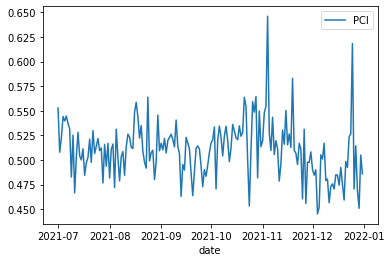

In [22]:
x.plot(x="date", y=["PCI"])